

> Portions of this work are based on the [**Link Prediction on MovieLens**](https://colab.research.google.com/drive/1xpzn1Nvai1ygd_P5Yambc_oe4VBPK_ZT?usp=sharing) and [**Link Regression on MovieLens**](https://colab.research.google.com/drive/1N3LvAO0AXV4kBPbTMX866OwJM9YS6Ji2?usp=sharing) notebooks provided by the [PyTorch Geometric](https://pytorch-geometric.readthedocs.io/) team.
>
> These resources are released under the MIT License.



**\[1]** M. Fey, "Link Prediction on MovieLens," *PyTorch Geometric Tutorials*, Google Colab, Apr. 2023. \[Online]. Available: [https://colab.research.google.com/drive/1xpzn1Nvai1ygd\_P5Yambc\_oe4VBPK\_ZT](https://colab.research.google.com/drive/1xpzn1Nvai1ygd_P5Yambc_oe4VBPK_ZT)


**\[2]** M. Fey, "Link Regression on MovieLens," *PyTorch Geometric Tutorials*, Google Colab, Apr. 2023. \[Online]. Available: [https://colab.research.google.com/drive/1N3LvAO0AXV4kBPbTMX866OwJM9YS6Ji2](https://colab.research.google.com/drive/1N3LvAO0AXV4kBPbTMX866OwJM9YS6Ji2)

# Music Recommendation Dataset - EDA & Knowledge Graph Builder

In [ ]:
# Exploratory Data Analysis
import os
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
import networkx as nx
from collections import defaultdict

!unzip KGRec-dataset.zip


In [6]:
# Set your data path here
base_path = Path('KGRec-dataset/KGRec-music')
desc_path = base_path / 'descriptions'
tags_path = base_path / 'tags'
interactions_file = base_path / 'implicit_lf_dataset.csv'

## 1. Exploratory Data Analysis

In [7]:
# Analysis and visualization of Interactions
interactions = pd.read_csv(interactions_file, sep='\t', header=None, names=['user_id', 'item_id', 'interaction'], encoding='utf-8')

print("Number of unique users:", interactions['user_id'].nunique())
print("Number of unique items:", interactions['item_id'].nunique())
print("Total interactions:", len(interactions))


Number of unique users: 5199
Number of unique items: 8640
Total interactions: 751531


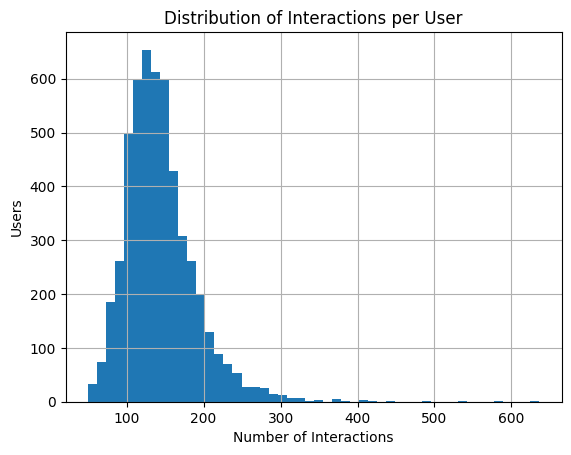

In [8]:
interactions.groupby('user_id').size().hist(bins=50)
plt.title("Distribution of Interactions per User")
plt.xlabel("Number of Interactions")
plt.ylabel("Users")
plt.show()


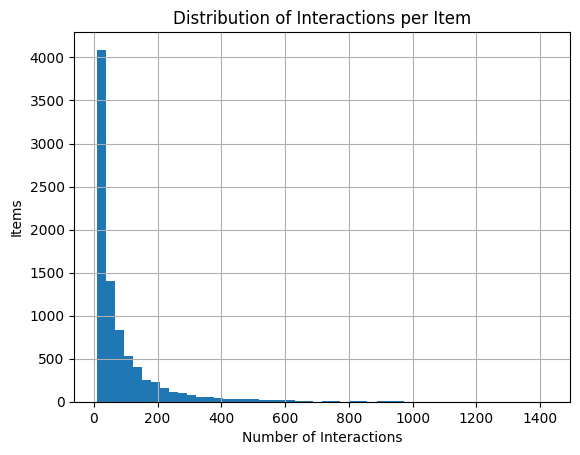

In [9]:
interactions.groupby('item_id').size().hist(bins=50)
plt.title("Distribution of Interactions per Item")
plt.xlabel("Number of Interactions")
plt.ylabel("Items")
plt.show()


In [11]:
# Analysis and visualization of Tags
tagged_items = set(f.replace('.txt', '') for f in os.listdir(tags_path))
total_items = set(interactions['item_id'].unique())
untagged_items = total_items - tagged_items

print(f"Total items with tags: {len(tagged_items)}")
print(f"Total items without tags: {len(untagged_items)}")

Total items with tags: 8239
Total items without tags: 8640


Reading tags: 100%|██████████| 8239/8239 [00:00<00:00, 18868.79it/s]


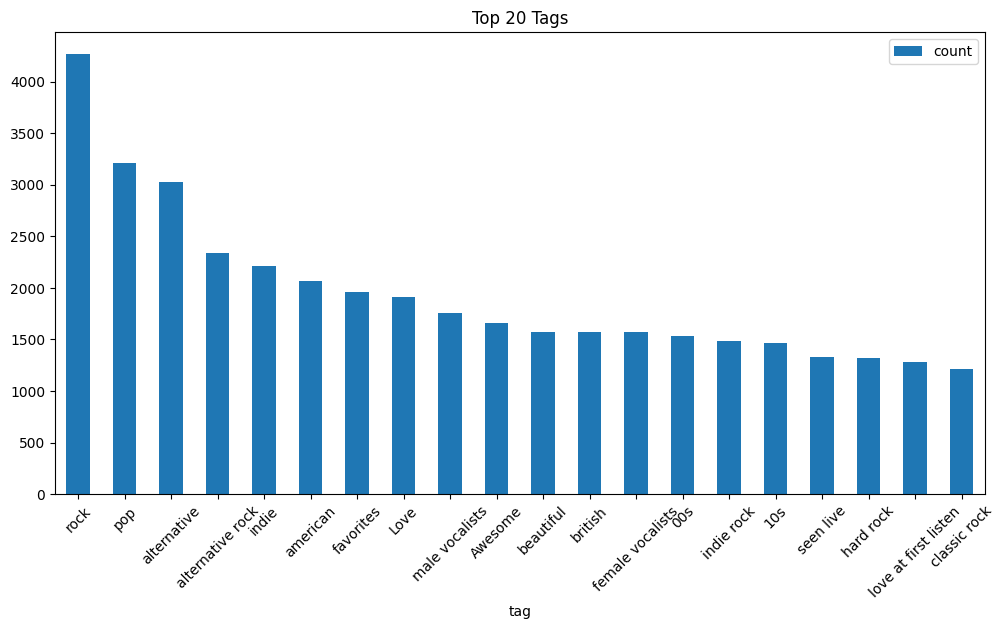

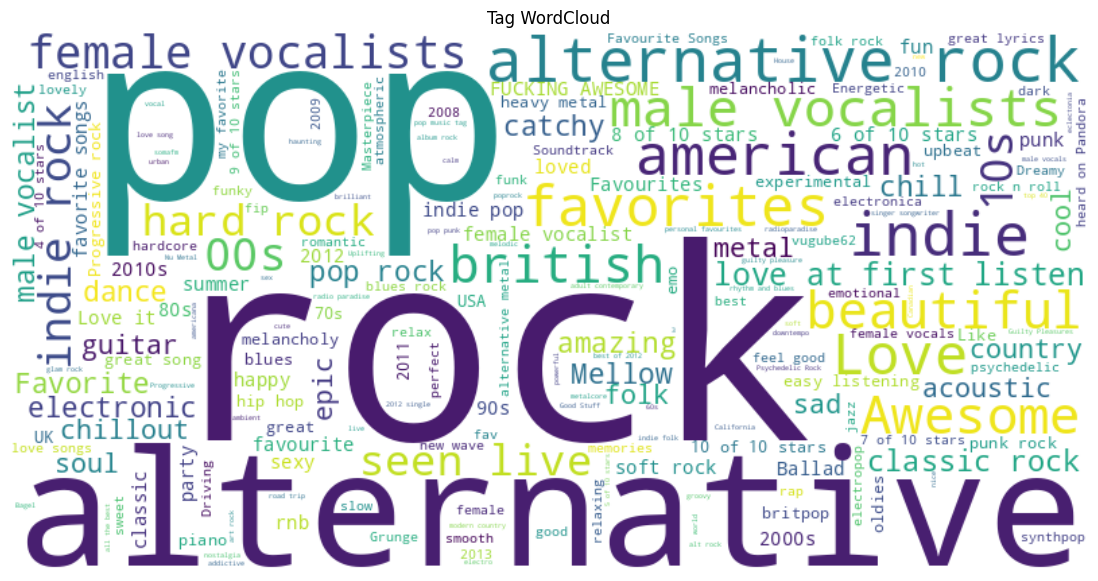

In [12]:
from collections import Counter

tag_counter = Counter()

for tag_file in tqdm(tagged_items, desc="Reading tags"):
    with open(tags_path / f"{tag_file}.txt", 'r', encoding='utf-8') as f:
        tags = f.read().strip().split()
        tags = [tag.replace("-", " ") for tag in tags]
        tag_counter.update(tags)

tags_df = pd.DataFrame(tag_counter.most_common(20), columns=['tag', 'count'])
tags_df.plot(kind='bar', x='tag', y='count', title='Top 20 Tags', figsize=(12, 6))
plt.xticks(rotation=45)
plt.show()

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(tag_counter)
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Tag WordCloud")
plt.show()


In [13]:
tagged_items = set(f.replace('.txt', '') for f in os.listdir(tags_path))
total_items = set(interactions['item_id'].unique())
untagged_items = total_items - tagged_items

print(f"Total items with tags: {len(tagged_items)}")
print(f"Total items without tags: {len(untagged_items)}")


Total items with tags: 8239
Total items without tags: 8640


Processing descriptions: 100%|██████████| 8640/8640 [00:00<00:00, 15221.10it/s]


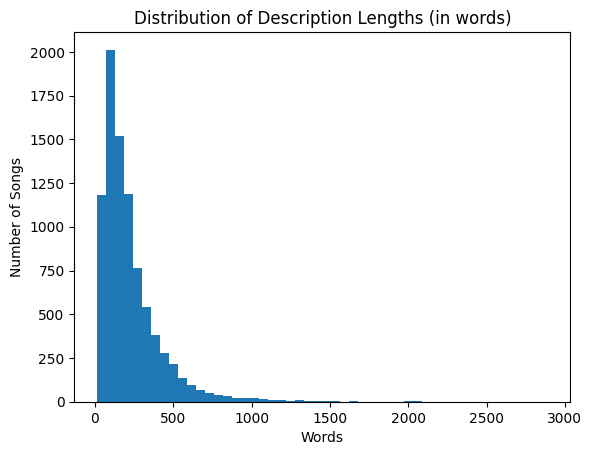

Avg description length: 225.27 words


In [14]:
# Analysis and visualization of Descriptions
desc_lengths = []

for desc_file in tqdm(os.listdir(desc_path), desc="Processing descriptions"):
    with open(desc_path / desc_file, 'r', encoding='utf-8') as f:
        text = f.read().strip()
        desc_lengths.append(len(text.split()))

plt.hist(desc_lengths, bins=50)
plt.title("Distribution of Description Lengths (in words)")
plt.xlabel("Words")
plt.ylabel("Number of Songs")
plt.show()

print(f"Avg description length: {sum(desc_lengths)/len(desc_lengths):.2f} words")


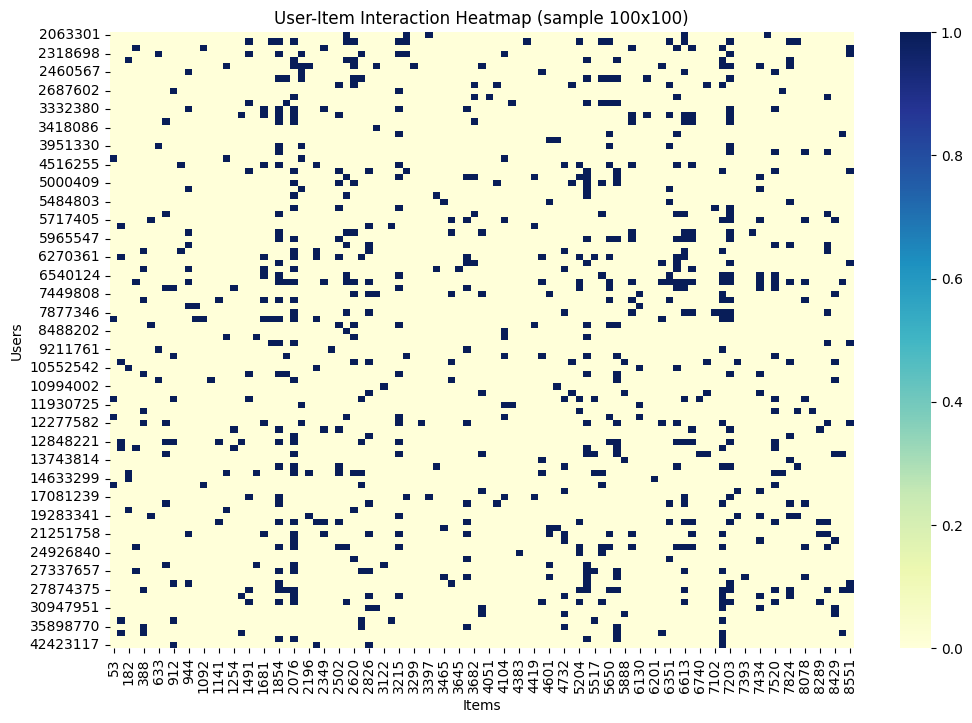

In [15]:
sample_users = interactions['user_id'].sample(n=100, random_state=42).unique()
sample_items = interactions['item_id'].sample(n=100, random_state=42).unique()
heatmap_data = interactions[interactions['user_id'].isin(sample_users) & interactions['item_id'].isin(sample_items)]

pivot = heatmap_data.pivot_table(index='user_id', columns='item_id', values='interaction', fill_value=0)
plt.figure(figsize=(12, 8))
sns.heatmap(pivot, cmap='YlGnBu')
plt.title("User-Item Interaction Heatmap (sample 100x100)")
plt.xlabel("Items")
plt.ylabel("Users")
plt.show()


# Model and training

In [ ]:
# By default in a Jupyter notebook, a cell with multiple print commands, when run, would print only the last one.
# This piece of code would modify that to print all the relevant lines in the cell.
from IPython.core.interactiveshell import InteractiveShell
import os
InteractiveShell.ast_node_interactivity = "all"

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
from torch_geometric.nn import SAGEConv, to_hetero, GATConv
from torch_geometric.data import HeteroData
import torch.nn.functional as F
import torch
from torch import Tensor
from typing import Protocol
import torch_geometric.transforms as T
from math import floor, ceil
from torch_geometric.loader import LinkNeighborLoader
import tqdm
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, f1_score, precision_score, recall_score, precision_recall_curve, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sentence_transformers import SentenceTransformer
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import ray
from ray import tune, train, remote
from ray.tune.schedulers import ASHAScheduler
from typing import Any, Type
import tempfile
from ray.train import Checkpoint

/usr/local/lib/python3.11/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-04-27 21:49:32,728	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-04-27 21:49:32,827	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [ ]:
print(torch.__version__)

2.6.0+cu118


## Constants and Hyperparameter Variables

In [ ]:
ROOT_DATA_PATH = "/home/appdev/data/CMPE/252/KGRec-dataset/KGRec-dataset"
MUSIC_DIR = "KGRec-music"
CUSTOM_AUDIO_DIR = "custom_music"
SAVE_RESULTS_PATH = "/home/appdev/data/CMPE/252"
TENSORBOARD_OUTPUT_PATH = "runs/gnn_experiment"

SEED = 101
CUSTOM_USER_ID: int | None = None
CUSTOM_NODE_ID: int | None = None

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

NUM_EPOCHS: int = 30
BATCH_SIZE: int = 128
OPTIMIZER_LEARNING_RATE: int = 0.001
WEIGHT_DECAY: float = 0.01

NUM_NEIGHBORS = [20, 10]
NEG_SAMPLING_RATIO = 2.0
GNN_HIDDEN_CHANNELS: int = 32
NUM_ATTENTION_HEADS: int = 4
# Whether to concatenate or average the heads' outputs.
# True	(hidden_channels * num_heads) All attention head outputs are concatenated into one long vector
# False	(hidden_channels) Attention head outputs are averaged (or summed) into a single vector
CONCATENATE_GAT_GNN_HEADS_OUTPUT: bool = False
DROPOUT: float = 0.3
MLP_HIDDEN_CHANNELS: int = 32

TOP_K_AUDIO_RECOMMENDATION: int = 10

In [ ]:
torch.manual_seed(SEED)

`pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.6.0+cu118.html`

## Model architecture

In [ ]:
class GSAGE_GNN(torch.nn.Module):
    def __init__(self, hidden_channels, dropout=0.3):
        super().__init__()
        self.dropout = torch.nn.Dropout(p=dropout)

        # dimensions are inferred later
        # The (-1, -1) refers to source and target node feature dimensions, which are infered during first forwrd pass.
        self.conv1 = SAGEConv((-1, -1), hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)

    def forward(self, x, edge_index) -> Tensor:
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return x

class GAT_GNN(torch.nn.Module):
    def __init__(self, hidden_channels, num_attention_heads: int, concatenate_heads_output: bool, dropout=0.3):
        super().__init__()
        self.dropout = torch.nn.Dropout(p=dropout)
        self.num_attention_heads = num_attention_heads
        self.concatenate_heads_output = concatenate_heads_output

        # dimensions are inferred later
        # The (-1, -1) refers to source and target node feature dimensions.
        # Use 2 attention heads in the first layer (you can adjust this)
        self.conv1 = GATConv((-1, -1), hidden_channels, heads=self.num_attention_heads, concat=True, add_self_loops=False)
        self.conv2 = GATConv(hidden_channels * self.num_attention_heads, hidden_channels, heads=self.num_attention_heads, concat=self.concatenate_heads_output, add_self_loops=False)

    def forward(self, x, edge_index) -> Tensor:
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return x

# classifier applies the dot-product between source and destination
# node embeddings to derive edge-level predictions:
class DotProductClassifier(torch.nn.Module):
    def forward(self, x_user: Tensor, x_music: Tensor, edge_label_index: Tensor) -> Tensor:
        # Convert node embeddings to edge-level representations
        edge_feat_user = x_user[edge_label_index[0]]
        edge_feat_music = x_music[edge_label_index[1]]

        # Apply dot-product to get a prediction per supervision edge:
        return (edge_feat_user * edge_feat_music).sum(dim=-1)

class EdgeMLPClassifier(torch.nn.Module):
    def __init__(self, input_channels: int, hidden_channels: int, dropout=0.3):
        super().__init__()
        # 2 * because you concatenate user and music node embeddings
        self.lin1 = torch.nn.Linear(2 * input_channels, hidden_channels)
        self.lin2 = torch.nn.Linear(hidden_channels, hidden_channels)
        self.lin3 = torch.nn.Linear(hidden_channels, 1)
        self.dropout = dropout

    def forward(self, x_user: Tensor, x_music: Tensor, edge_label_index):
        row, col = edge_label_index
        z = torch.cat([x_user[row], x_music[col]], dim=-1)
        z = self.lin1(z).relu()
        z = F.dropout(z, p=self.dropout, training=self.training)
        z = self.lin2(z).relu()
        z = F.dropout(z, p=self.dropout, training=self.training)
        z = self.lin3(z)
        return z.view(-1)


class Model(torch.nn.Module):
    def __init__(self, hidden_channels, gnn, graph: HeteroData, classifier,
                 learn_user_embeddings: bool = True, learn_item_embeddings: bool = True,
                 user_key: str = "user", item_key: str = "music", relationship_key: str = "interacts"):
        super().__init__()
        # Since the dataset does not come with rich features, we also learn two
        # embedding matrices for users and music:
        self.user_key = user_key
        self.item_key = item_key
        self.relationship_key = relationship_key
        self.learn_user_embeddings = learn_user_embeddings
        self.learn_item_embeddings = learn_item_embeddings

        if learn_user_embeddings:
            self.user_emb = torch.nn.Embedding(graph[user_key].num_nodes, hidden_channels)
        if learn_item_embeddings:
            self.music_emb = torch.nn.Embedding(graph[item_key].num_nodes, hidden_channels)

        # Instantiate homogeneous GNN:
        self.gnn = gnn

        # Convert GNN model into a heterogeneous variant:
        self.gnn = to_hetero(self.gnn, metadata=graph.metadata())

        self.classifier = classifier

    def forward(self, data: HeteroData) -> Tensor:
        x_dict = {
          self.user_key: self.user_emb(data[self.user_key].node_id) if self.learn_user_embeddings else data[self.user_key].x,
        #   below transforms existing node features and adds it to a to node embeddings that we want to
        #   also learn too based on the training
        #   self.relationship_key: self.music_lin(data[self.item_key].x) + self.music_emb(data[self.item_key].node_id),
          self.item_key: self.music_emb(data[self.item_key].node_id) if self.learn_item_embeddings else data[self.item_key].x,
        }

        # `x_dict` holds feature matrices of all node types
        # `edge_index_dict` holds all edge indices of all edge types
        x_dict = self.gnn(x_dict, data.edge_index_dict)

        pred = self.classifier(
            x_dict[self.user_key],
            x_dict[self.item_key],
            data[self.user_key, self.relationship_key, self.item_key].edge_label_index,
        )

        return pred

    def recommend(self, data: HeteroData, node_id: int, top_k: int) -> torch.Tensor:
        self.eval()
        with torch.no_grad():
            # Step 1: Build input node features
            x_dict = {
                self.user_key: self.user_emb(data[self.user_key].node_id) if self.learn_user_embeddings else data[self.user_key].x,
                self.item_key: self.music_emb(data[self.item_key].node_id) if self.learn_item_embeddings else data[self.item_key].x,
            }

            # Step 2: Get node embeddings via GNN
            z_dict = self.gnn(x_dict, data.edge_index_dict)

            # Step 3: Create edge index of user-to-all-items
            num_items = z_dict[self.item_key].size(0)
            device = z_dict[self.item_key].device
            all_items = torch.arange(num_items, device=device)
            user_node_id = torch.full_like(all_items, fill_value=node_id)
            edge_index = torch.stack([user_node_id, all_items], dim=0)  # shape: [2, num_items]

            # Step 4: Score each user-item pair
            scores = self.classifier(z_dict[self.user_key], z_dict[self.item_key], edge_index)

            assert scores.size(0) == data[self.item_key].num_nodes

            # Step 5: Mask out known interactions
            # Move to CPU to safely index with user_id
            edge_index_cpu = data[self.user_key, self.relationship_key, self.item_key].edge_index.cpu()
            user_mask = edge_index_cpu[0] == node_id

            # # Mask out already-interacted items by setting their score to -inf
            if user_mask.sum() > 0:
                interacted_items = edge_index_cpu[1][user_mask].to(device)
                # Mask out only if item index is in valid range
                interacted_items = interacted_items[interacted_items < scores.size(0)]
                scores[interacted_items] = float("-inf")
            else:
                print(f"⚠️ No known interactions for user node id of {node_id} — skipping mask.")

            # Step 5: Return top-k recommended item indices
            topk_indices = scores.topk(top_k).indices
            return all_items[topk_indices]

In [ ]:
# Define a protocol
class NodeEmbeddingBuilder(Protocol):
    def embed(self, **kwargs) -> Tensor:
        ...

class SingleScalarNodeEmbeddings:
    def __init__(self, number_nodes: int, single_scalar: float):
        # self.number_nodes:int = number_nodes
        self.single_scalar: float = single_scalar

    def embed(self, number_nodes) -> Tensor:
        """
        number_nodes: int
        """
        return torch.tensor(np.asarray([[self.single_scalar] for _ in range(number_nodes)]), dtype=torch.float32)

class SentenceTransformerNodeEmbeddings:
    def __init__(self, nlp_model: SentenceTransformer):
        self.nlp_model: SentenceTransformer = nlp_model

    def embed(self, node_text) -> Tensor:
        """
        node_text: container holding text to generate embeddings for [number of nodes, 1]
        """
        # assert len(node_ids_and_node_text[node_id_col]) == len(node_ids_and_node_text[node_text_col])
        embeddings = self.nlp_model.encode(
            node_text,
            convert_to_tensor=True,
            show_progress_bar=True
        )
        embeddings.shape
        print(type(embeddings))
        return embeddings


In [ ]:
def recommend_music(top_k: int, model: Model, unique_user_id_df: pd.DataFrame, unique_music_id_df: pd.DataFrame,
                    user_id: int, graph, device, verbose: bool):
    user_node_id = unique_user_id_df[unique_user_id_df["user_id"] == user_id]["mapped_node_id"].item()
    top_items = model.recommend(data=graph.to(device), node_id=user_node_id, top_k=top_k)

    # Convert tensor to numpy or list
    recommended_mapped_ids = top_items.cpu().numpy()

    # Get rows from your metadata DataFrame
    recommended_songs = unique_music_id_df[unique_music_id_df["mapped_node_id"].isin(recommended_mapped_ids)]

    # keep ordering by score so top recommendations are at the top and decrease downwards
    recommended_songs = recommended_songs.set_index("mapped_node_id").loc[recommended_mapped_ids].reset_index()

    if verbose:
        display(unique_user_id_df[unique_user_id_df["user_id"] == user_id])
        print(f"Max node Id: {unique_user_id_df['mapped_node_id'].max()}")
        print(f"Node Id that maps to the user_id: {user_node_id}")
        print("Recommended item indices:", top_items)

    print(f"Recommended top {top_k} songs: ")
    display(recommended_songs)

def get_audio_file_contents(data_file_path: str) -> tuple[list[str], list[str]]:
    data_dir = Path(data_file_path)
    audio_ids: list[str] = []
    audio_file_contents: list[str] = []
    for file in data_dir.iterdir():
        if file.is_file():
            audio_id = file.stem
            content = file.read_text(encoding='utf-8')
            audio_ids.append(audio_id)
            audio_file_contents.append(content)
    return (audio_ids, audio_file_contents)

def add_new_user_and_music(raw_dataset_df: pd.DataFrame, music_descriptions_df: pd.DataFrame,
                              merged_desc_tags_df: pd.DataFrame, edges_merged_df: pd.DataFrame,
                              music_description_titles: list[str], music_description_text: list[str],
                              music_tags_text: list[str], verbose: bool):
    # new user is the one we will be add out music/audio to
    new_user_id = int(raw_dataset_df["user_id"].max()) + 1
    # new_user_id

    # Each music we add will get a unique music_id. A Dataframe of our music/audio is created.
    max_music_id = int(music_descriptions_df.music_id.max())

    new_audio_ids: list[int] = []
    for music_id_offset in range(len(music_description_titles)):
        max_music_id += 1
        new_audio_ids.append(max_music_id)

    new_audio_df = pd.DataFrame(
        data={
            "user_id": [new_user_id for _ in range(len(new_audio_ids))],
            "music_id": new_audio_ids,
            "description": [new_audio_name + new_audio_desc for new_audio_name, new_audio_desc in zip(music_description_titles, music_description_text)],
            "tag": music_tags_text
        }
    )

    # Added new user's audio to the Dataframe of music "nodes" and their text features
    new_merged_desc_tags_df = pd.concat([merged_desc_tags_df, new_audio_df.drop("user_id", axis="columns")], ignore_index=True)
    # new_merged_desc_tags_df.set_index(keys="music_id", inplace=True)

    # Adding new user's edges to the the original dataset edge "list"
    new_edges_merged_df = pd.concat([edges_merged_df, new_audio_df.drop(labels=["description", "tag"], axis="columns")], ignore_index=True)

    if verbose:
        print(f"New add user: {new_user_id}")
        print(f"Max music_id in original dataset: {music_descriptions_df.music_id.max()}")
        print(f"New  music Id generated for new music being added:")
        print(new_audio_ids)
        print(f"New music descriptions and tags for new user to be added to original dataset (showing only the head(10) of Dataframe):")
        display(new_audio_df.head(10))
        print("After merged with custom audio with original dataset (showing the tail(10) of the merged datasets):")
        display(new_merged_desc_tags_df.shape)
        display(new_merged_desc_tags_df.tail(10))
        print("After merged with custom audio 'EDGE LIST' with original dataset (showing the tail(10) of the merged datasets):")
        display(new_edges_merged_df.shape)
        display(new_edges_merged_df.tail(10))

    return new_user_id, new_merged_desc_tags_df, new_edges_merged_df

## Load raw data

In [ ]:
raw_df = pd.read_csv(f"{ROOT_DATA_PATH}/{MUSIC_DIR}/implicit_lf_dataset.csv", sep="\t", header=None, names=["user_id", "music_id", "interaction"])
raw_df.shape
raw_df.head(10)

(751531, 3)

,user_id,music_id,interaction
0,4855132,1302,1
1,4855132,6666,1
2,4855132,2969,1
3,4855132,2968,1
4,4855132,3320,1
5,4855132,4478,1
6,4855132,5743,1
7,4855132,3326,1
8,4855132,4470,1
9,4855132,6082,1


In [ ]:
raw_df['interaction'].describe()
raw_df["user_id"].nunique()

count    751531.0
mean          1.0
std           0.0
min           1.0
25%           1.0
50%           1.0
75%           1.0
max           1.0
Name: interaction, dtype: float64

5199

In [ ]:
song_descriptions = get_audio_file_contents(f"{ROOT_DATA_PATH}/{MUSIC_DIR}/descriptions")
song_tags = get_audio_file_contents(f"{ROOT_DATA_PATH}/{MUSIC_DIR}/tags")

# custom_audio_descriptions = get_audio_file_contents(f"{ROOT_DATA_PATH}/{MUSIC_DIR}/{CUSTOM_AUDIO_DIR}/descriptions")
# custom_audio_tags = get_audio_file_contents(f"{ROOT_DATA_PATH}/{MUSIC_DIR}/{CUSTOM_AUDIO_DIR}/tags")

In [ ]:
music_descriptions_df = pd.DataFrame(
    data={
        # "music_id": song_descriptions[0],
        "music_id": pd.Series(song_descriptions[0], dtype=int),
        "description": song_descriptions[1]
    }
)
music_tags_df = pd.DataFrame(
    data={
        "music_id": pd.Series(song_tags[0], dtype=int),
        "tag": song_tags[1]
    }
)

merged_desc_tags_df = pd.merge(
    left=music_descriptions_df,
    right=music_tags_df,
    on="music_id",
    how="outer"
)
# merged_desc_tags_df.set_index(keys="music_id", inplace=True)
merged_desc_tags_df.shape
merged_desc_tags_df.head()

(8640, 3)

,music_id,description,tag
0,1,This ultra experimental number features some u...,mathematical songs-with-individual-pictures in...
1,2,The third single from Country music artist Cra...,my-favorite country new-country great-song
2,3,Frontman Charlie Fink 's lyrics for Last Night...,beautiful indie sweet pop indie-pop violin alt...
3,4,"The sequel to Drake 's Thank Me Later track , ...",fucked-up-shawty-awwwwwwwww-yeah drake-fig dat...
4,5,The `` Black Rain '' is a metaphor for oil .\n...,Iron-Maiden rockhard classic-british-heavy-met...


In [ ]:
edges_merged_df = raw_df.drop("interaction", axis="columns")
edges_merged_df.shape
edges_merged_df.head()

(751531, 2)

,user_id,music_id
0,4855132,1302
1,4855132,6666
2,4855132,2969
3,4855132,2968
4,4855132,3320


uncomment back in if one wants to add a new user and new music else original dataset will be used

In [ ]:
# CUSTOM_USER_ID, merged_desc_tags_df, edges_merged_df = add_new_user_and_music(
#     raw_dataset_df=raw_df,
#     music_descriptions_df=music_descriptions_df,
#     merged_desc_tags_df=merged_desc_tags_df,
#     edges_merged_df=edges_merged_df,
#     music_description_titles=custom_audio_descriptions[0],
#     music_description_text=custom_audio_descriptions[1],
#     music_tags_text=custom_audio_tags[1],
#     verbose=True
# )

### Adding music we like as custom user

In [ ]:
# # custom user is the one we will be add out music/audio to
# CUSTOM_USER_ID = int(raw_df["user_id"].max()) + 1
# CUSTOM_USER_ID

Each music we add will get a unique music_id. A Dataframe of our music/audio is created.

In [ ]:
# max_music_id = int(music_descriptions_df.music_id.max())
# max_music_id
# custom_audio_ids: list[int] = []
# for music_id_offset in range(len(custom_audio_descriptions[0])):
#     max_music_id += 1
#     custom_audio_ids.append(max_music_id)

# custom_audio_ids
# custom_audio_df = pd.DataFrame(
#     data={
#         "user_id": [CUSTOM_USER_ID for _ in range(len(custom_audio_ids))],
#         "music_id": custom_audio_ids,
#         "description": [custom_audio_name + custom_audio_desc for custom_audio_name, custom_audio_desc in zip(custom_audio_descriptions[0], custom_audio_descriptions[1])],
#         "tag": custom_audio_tags[1]
#     }
# )

# custom_audio_df.head(10)

Added custom user's audio to the Dataframe of music "nodes" and their text features

In [ ]:
# merged_desc_tags_df = pd.concat([merged_desc_tags_df, custom_audio_df.drop("user_id", axis="columns")], ignore_index=True)
# merged_desc_tags_df.set_index(keys="music_id", inplace=True)
# merged_desc_tags_df.tail(10)

Replacing null valued columns with an empty string.

In [ ]:
merged_desc_tags_df.tail(8)
merged_desc_tags_df.shape
merged_desc_tags_df.isna().sum()
merged_desc_tags_df["tag"] = merged_desc_tags_df["tag"].fillna("")
print("after replacing null tags with empty str")
merged_desc_tags_df.isna().sum()

,music_id,description,tag
8632,8633,Jessica Simpson wrote this about her boyfriend...,Jessica-Simpson Love Slow-Down Beautiful-Song ...
8633,8634,Matt Tuck in Metal Hammer magazine : `` It is ...,NaN
8634,8635,"Mat Kearney told CNN that this , `` is a crazy...",Love indie dg Workout good-beat pop rock
8635,8636,Florida Metalcore band Trivium introduce their...,NaN
8636,8637,Frontman Kele Okerke has spoken of how he list...,louder-is-never-enough power indie-rock indie ...
8637,8638,"This dynamic track might sound upbeat , but ly...",indie pretty-fucking-awesome pop female-vocals...
8638,8639,Vocalist Ryan Clark on bandsonfire.com about t...,christian-metal beautiful christian-rock xynod...
8639,8640,Snow Patrol 's second single from their sixth ...,beautiful music-for-a-rainy-summer-day indie a...


(8640, 3)

music_id         0
description      0
tag            401
dtype: int64

after replacing null tags with empty str


music_id       0
description    0
tag            0
dtype: int64

null values per column in `merged_desc_tags_df`

Adding custom user's edges to the the original dataset edge "list"

In [ ]:
# edges_merged_df = raw_df.drop("interaction", axis="columns")
# edges_merged_df.shape
# edges_merged_df.head()

# edges_merged_df = pd.concat([edges_merged_df, custom_audio_df.drop(labels=["description", "tag"], axis="columns")], ignore_index=True)
# print("After merged with custom audio:")
# edges_merged_df.tail(10)

## Creating Nodes

In [ ]:
# Create a mapping from unique user indices to range [0, num_user_nodes):
# mapped_node_id is the node a user is mapped to
unique_user_id = edges_merged_df['user_id'].unique()
unique_user_id = pd.DataFrame(data={
    'user_id': unique_user_id,
    'mapped_node_id': pd.RangeIndex(len(unique_user_id)),
})
# Create a mapping from unique music indices to range [0, num_music_nodes):
# mapped_node_id is the node a song is mapped to
unique_music_id = edges_merged_df["music_id"].unique()
unique_music_id = pd.DataFrame(data={
    'music_id': unique_music_id,
    'mapped_node_id': pd.RangeIndex(len(unique_music_id)),
})

CUSTOM_NODE_ID = unique_user_id[unique_user_id["user_id"] == CUSTOM_USER_ID]["mapped_node_id"]

unique_user_id.shape
unique_user_id.tail()
unique_music_id.shape
unique_music_id.tail(8)

(5199, 2)

,user_id,mapped_node_id
5194,6119607,5194
5195,7857475,5195
5196,6620733,5196
5197,2474568,5197
5198,22627679,5198


(8640, 2)

,music_id,mapped_node_id
8632,2783,8632
8633,7838,8633
8634,4940,8634
8635,6426,8635
8636,4099,8636
8637,3680,8637
8638,7044,8638
8639,6589,8639


In [ ]:
merged_desc_tags_df.head()

,music_id,description,tag
0,1,This ultra experimental number features some u...,mathematical songs-with-individual-pictures in...
1,2,The third single from Country music artist Cra...,my-favorite country new-country great-song
2,3,Frontman Charlie Fink 's lyrics for Last Night...,beautiful indie sweet pop indie-pop violin alt...
3,4,"The sequel to Drake 's Thank Me Later track , ...",fucked-up-shawty-awwwwwwwww-yeah drake-fig dat...
4,5,The `` Black Rain '' is a metaphor for oil .\n...,Iron-Maiden rockhard classic-british-heavy-met...


In [ ]:
merged_desc_tags_df.set_index(keys="music_id", inplace=True)

unique_music_id = unique_music_id.merge(
    left_on="music_id",
    right=(merged_desc_tags_df["description"] + merged_desc_tags_df["tag"]).to_frame(name="music_desc_tag"),
    right_index=True,
)
unique_music_id.shape
unique_music_id.isna().sum()
unique_music_id.head()
unique_music_id.tail(8)

(8640, 3)

music_id          0
mapped_node_id    0
music_desc_tag    0
dtype: int64

,music_id,mapped_node_id,music_desc_tag
0,1302,0,This song is about the fleeting nature of Pop-...
1,6666,1,Johnson : `` It 's been around for a little wh...
2,2969,2,Guitarist Ryan Ross recalled to VH1 : `` That ...
3,2968,3,"This is a track from English indie rock band ,..."
4,3320,4,Frontman Harry McVeigh told The Sun January 16...


,music_id,mapped_node_id,music_desc_tag
8632,2783,8632,This is a track from the South African sibling...
8633,7838,8633,According to Neville Judd 's authorized biogra...
8634,4940,8634,Written for the soundtrack to the movie Kids i...
8635,6426,8635,JCB is a company that makes construction equip...
8636,4099,8636,On this Delta Blues flavored update of the tra...
8637,3680,8637,On this song Drake raps about his fast ascent ...
8638,7044,8638,This song finds lead singer Jon Davis question...
8639,6589,8639,This upbeat dance track features Sean Paul sin...


## Create Graph edges

In [ ]:
# Perform merge to obtain the edges from users and music:
interaction_user_id = pd.merge(edges_merged_df['user_id'], unique_user_id,
                            left_on='user_id', right_on='user_id', how='left')
ratings_user_id = torch.from_numpy(interaction_user_id['mapped_node_id'].values)
interaction_music_id = pd.merge(edges_merged_df['music_id'], unique_music_id,
                            left_on='music_id', right_on='music_id', how='left')
interaction_music_id = torch.from_numpy(interaction_music_id['mapped_node_id'].values)

# With this, we are ready to construct our `edge_index` in COO format
# following PyG semantics:
edge_index_user_to_music = torch.stack([ratings_user_id, interaction_music_id], dim=0)

# [2, number of edges]
# top list is source node and bottom list is destination node
print("Final edge indices pointing from users to music:")
edge_index_user_to_music[:, :10]

Final edge indices pointing from users to music:


tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]])

"With this, we are ready to initialize our HeteroData object and pass the necessary information to it. Note that we also pass in a node_id vector to each node type in order to reconstruct the original node indices from sampled subgraphs. We also take care of adding reverse edges to the HeteroData object. This allows our GNN model to use both directions of the edge for message passing:" - link pred notebook

In [ ]:
node_embedder = SentenceTransformerNodeEmbeddings(
    nlp_model=SentenceTransformer("all-MiniLM-L6-v2")
)

In [ ]:
text_nlp_embed = node_embedder.embed(node_text=unique_music_id["music_desc_tag"])

Batches: 100%|██████████| 270/270 [00:19<00:00, 13.89it/s]

<class 'torch.Tensor'>


In [ ]:
text_nlp_embed.shape

torch.Size([8640, 384])

## Creating Bipartite Graph    

In [ ]:
data = HeteroData()

# Save node indices:
data["user"].node_id = torch.arange(len(unique_user_id))

# all music nodes possible should be used but we only have music nodes
# that have been interacted by users anyways in our dataset
data["music"].node_id = torch.arange(len(unique_music_id))

# Add the node features and edge indices:
# data["music"].x = node_embedder.embed() # [num_music, num_music_features]
data["music"].x = text_nlp_embed # [num_music, num_music_features]
data["user", "interacts", "music"].edge_index = edge_index_user_to_music  # [2, num_interactions/downloads]

# We also need to make sure to add the reverse edges from music to users
# in order to let a GNN be able to pass messages in both directions.
# We can leverage the `T.ToUndirected()` transform for this from PyG:

data = T.ToUndirected()(data=data)

print(data)

assert data.node_types == ["user", "music"]
assert data.edge_types == [("user", "interacts", "music"),
                           ("music", "rev_interacts", "user")]
assert data["user"].num_nodes == len(unique_user_id)
assert data["user"].num_features == 0 # for now?
assert data["music"].num_nodes == len(unique_music_id)
# assert data["music"].num_features == 1 # for now?
assert data["user", "interacts", "music"].num_edges == edges_merged_df.shape[0]
assert data["music", "rev_interacts", "user"].num_edges == edges_merged_df.shape[0]

HeteroData(
  user={ node_id=[5199] },
  music={
    node_id=[8640],
    x=[8640, 384],
  },
  (user, interacts, music)={ edge_index=[2, 751531] },
  (music, rev_interacts, user)={ edge_index=[2, 751531] }
)


In [ ]:
# For this, we first split the set of edges into
# training (80%), validation (10%), and testing edges (10%).
# Across the training edges, we use 70% of edges for message passing,
# and 30% of edges for supervision.
# We further want to generate fixed negative edges for evaluation with a ratio of 2:1.
# Negative edges during training will be generated on-the-fly, so we don't want to
# add them to the graph right away.
# Overall, we can leverage the `RandomLinkSplit()` transform for this from PyG:
train_data_size = 0.8
val_data_size = 0.1
test_data_size = 0.1
disjoint_train_ratio = 0.3
transform = T.RandomLinkSplit(
    num_val=val_data_size,
    num_test=test_data_size,
    disjoint_train_ratio=disjoint_train_ratio,
    neg_sampling_ratio=NEG_SAMPLING_RATIO,
    add_negative_train_samples=False,
    edge_types=("user", "interacts", "music"),
    rev_edge_types=("music", "rev_interacts", "user"),
)

train_data, val_data, test_data = transform(data.clone())
print("Training data:")
print("==============")
print(train_data)
print()
print("Validation data:")
print("================")
print(val_data)

# assert train_data["user", "interacts", "music"].num_edges == floor((751531 * train_data_size) - (751531 * train_data_size * disjoint_train_ratio))
assert train_data["user", "interacts", "music"].num_edges == ceil((edges_merged_df.shape[0] * 0.8) - (edges_merged_df.shape[0] * 0.8 * 0.3))
assert train_data["music", "rev_interacts", "user"].num_edges == ceil((edges_merged_df.shape[0] * 0.8) - (edges_merged_df.shape[0] * 0.8 * 0.3))
# # No negative edges added:
assert train_data["user", "interacts", "music"].edge_label.min() == 1
assert train_data["user", "interacts", "music"].edge_label.max() == 1

Training data:
HeteroData(
  user={ node_id=[5199] },
  music={
    node_id=[8640],
    x=[8640, 384],
  },
  (user, interacts, music)={
    edge_index=[2, 420858],
    edge_label=[180367],
    edge_label_index=[2, 180367],
  },
  (music, rev_interacts, user)={ edge_index=[2, 420858] }
)

Validation data:
HeteroData(
  user={ node_id=[5199] },
  music={
    node_id=[8640],
    x=[8640, 384],
  },
  (user, interacts, music)={
    edge_index=[2, 601225],
    edge_label=[225459],
    edge_label_index=[2, 225459],
  },
  (music, rev_interacts, user)={ edge_index=[2, 601225] }
)


In [ ]:
# create a mini-batch loader that will generate subgraphs that can be used as input into our GNN

# In the first hop, we sample at most 20 neighbors.
# In the second hop, we sample at most 10 neighbors.
# In addition, during training, we want to sample negative edges on-the-fly with
# a ratio of 2:1.
# We can make use of the `loader.LinkNeighborLoader` from PyG:

# Define seed edges:
edge_label_index = train_data["user", "interacts", "music"].edge_label_index
edge_label = train_data["user", "interacts", "music"].edge_label

train_loader = LinkNeighborLoader(
    data=data,
    num_neighbors=NUM_NEIGHBORS,
    neg_sampling_ratio=NEG_SAMPLING_RATIO,
    edge_label_index=(("user", "interacts", "music"), edge_label_index),
    edge_label=edge_label,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

# Inspect a sample:
sampled_data = next(iter(train_loader))

print("Sampled mini-batch:")
print("===================")
print(sampled_data)

assert sampled_data["user", "interacts", "music"].edge_label_index.size(1) == 3 * BATCH_SIZE
assert sampled_data["user", "interacts", "music"].edge_label.min() == 0
assert sampled_data["user", "interacts", "music"].edge_label.max() == 1

Sampled mini-batch:
HeteroData(
  user={
    node_id=[3636],
    n_id=[3636],
    num_sampled_nodes=[3],
  },
  music={
    node_id=[3348],
    x=[3348, 384],
    n_id=[3348],
    num_sampled_nodes=[3],
  },
  (user, interacts, music)={
    edge_index=[2, 27668],
    e_id=[27668],
    num_sampled_edges=[2],
    input_id=[128],
    edge_label_index=[2, 384],
    edge_label=[384],
  },
  (music, rev_interacts, user)={
    edge_index=[2, 31200],
    e_id=[31200],
    num_sampled_edges=[2],
  }
)


In [ ]:
# Evaluating a Heterogeneous Link-level GNN
def generate_roc_curve(probabilities, labels: np.ndarray, auc: float, display_plot: bool):
    fpr, tpr, thresholds = roc_curve(labels, probabilities)

    fig, ax = plt.subplots()
    ax.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
    ax.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("ROC Curve")
    ax.legend(loc="lower right")
    ax.grid(True)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    plt.tight_layout()

    if display_plot:
        plt.show()
    return fig

def generate_precision_recall_curve(probabilities, labels, display_plot: bool):
    precision, recall, _ = precision_recall_curve(labels, probabilities)

    fig, ax = plt.subplots()
    ax.plot(recall, precision, label="Precision-Recall Curve")
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.set_title("Precision-Recall Curve")
    ax.grid(True)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    plt.tight_layout()
    if display_plot:
        plt.show()

    return fig

def generate_confusion_matrix(y_true, y_pred, display_plot: bool):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", ax=ax)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    ax.set_title("Confusion Matrix")

    plt.tight_layout()

    if display_plot:
        plt.show()
    return fig


def calculate_metrics(probabilities, labels: np.ndarray, classification_threshold: float) -> dict[str, float]:
    # Apply sigmoid to convert logits to probabilities

    # Convert probabilities to binary predictions (threshold = classification_threshold)
    pred_labels = (probabilities >= classification_threshold).astype(int)

    # Compute metrics
    metrics: dict[str, float] = {
        "accuracy": accuracy_score(labels, pred_labels),
        "auc": roc_auc_score(labels, probabilities), # Use probabilities here
        "precision": precision_score(labels, pred_labels),
        "recall": recall_score(labels, pred_labels),
        "f1": f1_score(labels, pred_labels),
    }
    return metrics

def print_epoch_metrics_dict(epoch: int, avg_train_loss: float, metrics_dict: dict[str, float]) -> None:
    print(f"[Epoch {epoch}] Train Loss: {avg_train_loss:.4f} | Val Loss: {metrics_dict['non-train_loss']:.4f} | AUC: {metrics_dict['auc']:.4f} | Acc: {metrics_dict['accuracy']:.4f} | F1: {metrics_dict['f1']:.4f}")

def print_metrics_dict(metrics_dict: dict[str, float]) -> None:
    print(f"Loss: {metrics_dict['non-train_loss']:.4f} | AUC: {metrics_dict['auc']:.4f} | Acc: {metrics_dict['accuracy']:.4f} | F1: {metrics_dict['f1']:.4f}")

def log_metrics_to_tensorboard(writer, set_name: str, epoch: int, metric_dict):
    writer.add_scalar(f"Loss/{set_name}", metric_dict["non-train_loss"], epoch)
    writer.add_scalar(f"AUC/{set_name}", metric_dict["auc"], epoch)
    writer.add_scalar(f"Accuracy/{set_name}", metric_dict["accuracy"], epoch)
    writer.add_scalar(f"F1/{set_name}", metric_dict["f1"], epoch)
    writer.add_scalar(f"Precision/{set_name}", metric_dict["precision"], epoch)
    writer.add_scalar(f"Recall/{set_name}", metric_dict["recall"], epoch)

def log_plots_to_tensorboard(writer, set_name: str, epoch: int, probabilities, labels, metrics_dict, classification_threshold: float, display_plots: bool, roc_curve: bool, precision_recall_curve: bool, confusion_matrix: bool):
    if roc_curve:
        roc_fig = generate_roc_curve(probabilities=probabilities, labels=labels, auc=metrics_dict["auc"], display_plot=display_plots)
        writer.add_figure(f"ROC Curve/{set_name}", roc_fig, global_step=epoch)
    if precision_recall_curve:
        per_rec_fig = generate_precision_recall_curve(probabilities=probabilities, labels=labels, display_plot=display_plots)
        writer.add_figure(f"PR Curve/{set_name}", per_rec_fig, global_step=epoch)
    if confusion_matrix:
        confusion_matrix_fig = generate_confusion_matrix(y_true=labels, y_pred=(probabilities >= classification_threshold).astype(int), display_plot=display_plots)
        writer.add_figure(f"Confusion Matrix/{set_name}", confusion_matrix_fig, global_step=epoch)

@torch.no_grad()
def test(model, dataLoader, device, display_progress_bars: bool = True):
    model.eval();

    predictions = []
    ground_truths = []
    batch_generator = tqdm.tqdm(dataLoader) if display_progress_bars else dataLoader
    for batch in batch_generator:
        batch = batch.to(device)
        predictions.append(model(batch))
        ground_truths.append(batch["user", "interacts", "music"].edge_label)
    return torch.cat(predictions), torch.cat(ground_truths)

In [ ]:
# Define the validation seed edges:
edge_label_index = val_data["user", "interacts", "music"].edge_label_index
edge_label = val_data["user", "interacts", "music"].edge_label

val_loader = LinkNeighborLoader(
    data=val_data,
    num_neighbors=NUM_NEIGHBORS,
    edge_label_index=(("user", "interacts", "music"), edge_label_index),
    edge_label=edge_label,
    batch_size=3 * BATCH_SIZE,
    shuffle=False,
)

sampled_data = next(iter(val_loader))

print("Sampled mini-batch:")
print("===================")
print(sampled_data)

assert sampled_data["user", "interacts", "music"].edge_label_index.size(1) == 3 * BATCH_SIZE
assert sampled_data["user", "interacts", "music"].edge_label.min() >= 0
assert sampled_data["user", "interacts", "music"].edge_label.max() <= 1

Sampled mini-batch:
HeteroData(
  user={
    node_id=[5178],
    n_id=[5178],
    num_sampled_nodes=[3],
  },
  music={
    node_id=[6993],
    x=[6993, 384],
    n_id=[6993],
    num_sampled_nodes=[3],
  },
  (user, interacts, music)={
    edge_index=[2, 40219],
    edge_label=[384],
    edge_label_index=[2, 384],
    e_id=[40219],
    num_sampled_edges=[2],
    input_id=[384],
  },
  (music, rev_interacts, user)={
    edge_index=[2, 41620],
    e_id=[41620],
    num_sampled_edges=[2],
  }
)


In [ ]:
model = Model(
    hidden_channels=GNN_HIDDEN_CHANNELS,
    gnn=GAT_GNN(
        hidden_channels=GNN_HIDDEN_CHANNELS,
        num_attention_heads=NUM_ATTENTION_HEADS,
        dropout=DROPOUT,
        concatenate_heads_output=CONCATENATE_GAT_GNN_HEADS_OUTPUT
        ),
    learn_item_embeddings=False,
    classifier=EdgeMLPClassifier(
        input_channels= NUM_ATTENTION_HEADS * GNN_HIDDEN_CHANNELS if CONCATENATE_GAT_GNN_HEADS_OUTPUT else GNN_HIDDEN_CHANNELS,
        hidden_channels=MLP_HIDDEN_CHANNELS
    ),
    graph=data,
)

model
print(f"Device: '{DEVICE}'")

model = model.to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=OPTIMIZER_LEARNING_RATE, weight_decay=WEIGHT_DECAY)

Model(
  (user_emb): Embedding(5199, 32)
  (gnn): GraphModule(
    (conv1): ModuleDict(
      (user__interacts__music): GATConv((-1, -1), 32, heads=4)
      (music__rev_interacts__user): GATConv((-1, -1), 32, heads=4)
    )
    (dropout): ModuleDict(
      (user): Dropout(p=0.3, inplace=False)
      (music): Dropout(p=0.3, inplace=False)
    )
    (conv2): ModuleDict(
      (user__interacts__music): GATConv(128, 32, heads=4)
      (music__rev_interacts__user): GATConv(128, 32, heads=4)
    )
  )
  (classifier): EdgeMLPClassifier(
    (lin1): Linear(in_features=64, out_features=32, bias=True)
    (lin2): Linear(in_features=32, out_features=32, bias=True)
    (lin3): Linear(in_features=32, out_features=1, bias=True)
  )
)

Device: 'cuda'


## Initial Model Training

In [ ]:
# training heterogeneous link-level GNN with no hyper parameter tuning

# Creates a `runs/` directory to store logs
run_id = datetime.now().strftime("%Y%m%d-%H%M%S")
writer = SummaryWriter(log_dir=f"{SAVE_RESULTS_PATH}/{TENSORBOARD_OUTPUT_PATH}_{run_id}")

for epoch in range(1, NUM_EPOCHS+1):
    # fix to prevent model info printing to output...
    _ = model.train()
    total_loss = total_examples = 0
    for batch in tqdm.tqdm(train_loader):
        optimizer.zero_grad()

        batch  = batch.to(DEVICE)
        predictions = model(batch)
        ground_truth = batch["user", "interacts", "music"].edge_label.to(DEVICE)
        loss = F.binary_cross_entropy_with_logits(predictions, ground_truth)

        loss.backward()
        optimizer.step()
        total_loss += float(loss) * predictions.numel()
        total_examples += predictions.numel()
    avg_train_loss = total_loss / total_examples
    writer.add_scalar("Loss/train", avg_train_loss, epoch)

    # --- Validation ---
    val_pred, val_label = test(model=model, dataLoader=val_loader, device=DEVICE)
    val_loss = F.binary_cross_entropy_with_logits(val_pred, val_label).item()

    val_probabilities = torch.sigmoid(val_pred).cpu().numpy()
    val_label_np = val_label.cpu().numpy()

    val_metrics = calculate_metrics(probabilities=val_probabilities, labels=val_label_np, classification_threshold=0.5)
    val_metrics["non-train_loss"] = val_loss
    print_epoch_metrics_dict(epoch, avg_train_loss, val_metrics)

    log_metrics_to_tensorboard(writer=writer, set_name="val", epoch=epoch, metric_dict=val_metrics)
    log_plots_to_tensorboard(
        writer=writer,
        set_name="val",
        epoch=epoch,
        probabilities=val_probabilities,
        labels=val_label_np,
        metrics_dict=val_metrics,
        classification_threshold=0.5,
        display_plots=False,
        roc_curve=True,
        precision_recall_curve=True,
        confusion_matrix=False
    )
writer.close()

100%|██████████| 588/588 [00:10<00:00, 56.50it/s]


[Epoch 1] Train Loss: 0.5280 | Val Loss: 0.6369 | AUC: 0.5989 | Acc: 0.6453 | F1: 0.2815


100%|██████████| 588/588 [00:10<00:00, 58.37it/s]


[Epoch 2] Train Loss: 0.4687 | Val Loss: 0.6088 | AUC: 0.6234 | Acc: 0.6676 | F1: 0.1038


100%|██████████| 588/588 [00:10<00:00, 58.37it/s]


[Epoch 3] Train Loss: 0.4454 | Val Loss: 0.6000 | AUC: 0.6490 | Acc: 0.6726 | F1: 0.0612


100%|██████████| 588/588 [00:10<00:00, 56.75it/s]


[Epoch 4] Train Loss: 0.4372 | Val Loss: 0.5786 | AUC: 0.7028 | Acc: 0.6599 | F1: 0.5160


100%|██████████| 588/588 [00:10<00:00, 57.87it/s]


[Epoch 5] Train Loss: 0.4306 | Val Loss: 0.5769 | AUC: 0.7004 | Acc: 0.6587 | F1: 0.5188


100%|██████████| 588/588 [00:10<00:00, 58.68it/s]


[Epoch 6] Train Loss: 0.4267 | Val Loss: 0.5722 | AUC: 0.7150 | Acc: 0.6558 | F1: 0.5753


100%|██████████| 588/588 [00:09<00:00, 58.93it/s]


[Epoch 7] Train Loss: 0.4223 | Val Loss: 0.5663 | AUC: 0.7186 | Acc: 0.6687 | F1: 0.5441


100%|██████████| 588/588 [00:10<00:00, 57.73it/s]


[Epoch 8] Train Loss: 0.4202 | Val Loss: 0.5719 | AUC: 0.7179 | Acc: 0.6669 | F1: 0.5531


100%|██████████| 588/588 [00:09<00:00, 58.94it/s]


[Epoch 9] Train Loss: 0.4162 | Val Loss: 0.5578 | AUC: 0.7306 | Acc: 0.6804 | F1: 0.5709


100%|██████████| 588/588 [00:10<00:00, 57.70it/s]


[Epoch 10] Train Loss: 0.4128 | Val Loss: 0.5724 | AUC: 0.7178 | Acc: 0.6593 | F1: 0.5691


100%|██████████| 588/588 [00:10<00:00, 57.77it/s]


[Epoch 11] Train Loss: 0.4107 | Val Loss: 0.5676 | AUC: 0.7335 | Acc: 0.6685 | F1: 0.5844


100%|██████████| 588/588 [00:10<00:00, 57.77it/s]


[Epoch 12] Train Loss: 0.4085 | Val Loss: 0.5642 | AUC: 0.7350 | Acc: 0.6729 | F1: 0.5768


100%|██████████| 588/588 [00:10<00:00, 57.37it/s]


[Epoch 13] Train Loss: 0.4063 | Val Loss: 0.5607 | AUC: 0.7327 | Acc: 0.6791 | F1: 0.5643


100%|██████████| 588/588 [00:10<00:00, 58.15it/s]


[Epoch 14] Train Loss: 0.4036 | Val Loss: 0.5800 | AUC: 0.7321 | Acc: 0.6576 | F1: 0.5865


100%|██████████| 588/588 [00:10<00:00, 54.56it/s]


[Epoch 15] Train Loss: 0.4017 | Val Loss: 0.5753 | AUC: 0.7359 | Acc: 0.6610 | F1: 0.5902


100%|██████████| 588/588 [00:10<00:00, 56.06it/s]


[Epoch 16] Train Loss: 0.4009 | Val Loss: 0.5646 | AUC: 0.7392 | Acc: 0.6775 | F1: 0.5809


100%|██████████| 588/588 [00:10<00:00, 56.77it/s]


[Epoch 17] Train Loss: 0.3984 | Val Loss: 0.5758 | AUC: 0.7300 | Acc: 0.6615 | F1: 0.5754


100%|██████████| 588/588 [00:10<00:00, 56.07it/s]


[Epoch 18] Train Loss: 0.3970 | Val Loss: 0.5711 | AUC: 0.7467 | Acc: 0.6690 | F1: 0.5992


100%|██████████| 588/588 [00:10<00:00, 56.33it/s]


[Epoch 19] Train Loss: 0.3952 | Val Loss: 0.5756 | AUC: 0.7383 | Acc: 0.6578 | F1: 0.5926


100%|██████████| 588/588 [00:10<00:00, 54.64it/s]


[Epoch 20] Train Loss: 0.3941 | Val Loss: 0.5648 | AUC: 0.7491 | Acc: 0.6749 | F1: 0.5952


100%|██████████| 588/588 [00:11<00:00, 53.14it/s]


[Epoch 21] Train Loss: 0.3927 | Val Loss: 0.5904 | AUC: 0.7292 | Acc: 0.6299 | F1: 0.6005


100%|██████████| 588/588 [00:10<00:00, 56.05it/s]


[Epoch 22] Train Loss: 0.3910 | Val Loss: 0.5732 | AUC: 0.7501 | Acc: 0.6622 | F1: 0.6044


100%|██████████| 588/588 [00:10<00:00, 56.32it/s]


[Epoch 23] Train Loss: 0.3901 | Val Loss: 0.5701 | AUC: 0.7446 | Acc: 0.6643 | F1: 0.5977


100%|██████████| 588/588 [00:10<00:00, 57.07it/s]


[Epoch 24] Train Loss: 0.3897 | Val Loss: 0.5847 | AUC: 0.7436 | Acc: 0.6491 | F1: 0.6039


100%|██████████| 588/588 [00:10<00:00, 57.00it/s]


[Epoch 25] Train Loss: 0.3879 | Val Loss: 0.5907 | AUC: 0.7424 | Acc: 0.6311 | F1: 0.6067


100%|██████████| 588/588 [00:10<00:00, 58.05it/s]


[Epoch 26] Train Loss: 0.3865 | Val Loss: 0.5673 | AUC: 0.7362 | Acc: 0.6736 | F1: 0.5662


100%|██████████| 588/588 [00:10<00:00, 54.56it/s]


[Epoch 27] Train Loss: 0.3859 | Val Loss: 0.6044 | AUC: 0.7299 | Acc: 0.6246 | F1: 0.5993


100%|██████████| 588/588 [00:10<00:00, 57.40it/s]


[Epoch 28] Train Loss: 0.3868 | Val Loss: 0.5781 | AUC: 0.7402 | Acc: 0.6609 | F1: 0.5930


100%|██████████| 588/588 [00:10<00:00, 56.79it/s]


[Epoch 29] Train Loss: 0.3848 | Val Loss: 0.5776 | AUC: 0.7442 | Acc: 0.6568 | F1: 0.6029


100%|██████████| 588/588 [00:10<00:00, 56.92it/s]


[Epoch 30] Train Loss: 0.3842 | Val Loss: 0.5930 | AUC: 0.7427 | Acc: 0.6486 | F1: 0.6050


-   val_loader (LinkNeighborLoader) iterates over the edges in the validation set
-   obtain the predictions on validation edges by running the model, and finally evaluate the performance of the model by computing the AUC score over the set of predictions and their corresponding ground-truth edges (including both positive and negative edges).

## Hyperparameter search

In [ ]:
def gat_mlp_model_factory(config: dict[str, Any], graph, model_class: Type[Model]) -> Model:
    model = model_class(
        hidden_channels=config["gnn_hidden_channels"],
        gnn=GAT_GNN(
            hidden_channels=config["gnn_hidden_channels"],
            num_attention_heads=config["num_attention_heads"],
            concatenate_heads_output=config["concatenate_gat_gnn_heads_output"],
            dropout=config["dropout"]
        ),
        learn_item_embeddings=False,
        classifier=EdgeMLPClassifier(
            input_channels=config["num_attention_heads"] * config["gnn_hidden_channels"] if config["concatenate_gat_gnn_heads_output"] else config["gnn_hidden_channels"],
            hidden_channels=config["mlp_hidden_channels"]
        ),
        graph=graph
    )
    return model

def generate_dataset_loaders(graph, val_data_size = 0.1, test_data_size = 0.1, batch_size = 128,
                             disjoint_train_ratio = 0.3, neg_sampling_ratio = 2.0, num_neighbors = [20, 10]):
    transform = T.RandomLinkSplit(
        num_val=val_data_size,
        num_test=test_data_size,
        disjoint_train_ratio=disjoint_train_ratio,
        neg_sampling_ratio=neg_sampling_ratio,
        add_negative_train_samples=False,
        edge_types=("user", "interacts", "music"),
        rev_edge_types=("music", "rev_interacts", "user"),
    )

    train_data, val_data, test_data = transform(graph)

    edge_label_index = train_data["user", "interacts", "music"].edge_label_index
    edge_label = train_data["user", "interacts", "music"].edge_label

    train_loader = LinkNeighborLoader(
        data=data,
        num_neighbors=num_neighbors,
        neg_sampling_ratio=neg_sampling_ratio,
        edge_label_index=(("user", "interacts", "music"), edge_label_index),
        edge_label=edge_label,
        batch_size=batch_size,
        shuffle=True,
    )

    edge_label_index = val_data["user", "interacts", "music"].edge_label_index
    edge_label = val_data["user", "interacts", "music"].edge_label

    val_loader = LinkNeighborLoader(
        data=val_data,
        num_neighbors=num_neighbors,
        edge_label_index=(("user", "interacts", "music"), edge_label_index),
        edge_label=edge_label,
        batch_size=3 * batch_size,
        shuffle=False,
    )

    edge_label_index = test_data["user", "interacts", "music"].edge_label_index
    edge_label = test_data["user", "interacts", "music"].edge_label

    test_loader = LinkNeighborLoader(
        data=test_data,
        num_neighbors=num_neighbors,
        edge_label_index=(("user", "interacts", "music"), edge_label_index),
        edge_label=edge_label,
        batch_size=3 * batch_size,
        shuffle=False,
    )

    return train_loader, val_loader, test_loader

def train_model_step(model, device, optimizer, train_loader, val_loader, classification_threshold=0.5):
    model.train();
    total_loss = total_examples = 0
    for batch in train_loader:
        optimizer.zero_grad()

        batch  = batch.to(device)
        predictions = model(batch)
        ground_truth = batch["user", "interacts", "music"].edge_label.to(device)
        loss = F.binary_cross_entropy_with_logits(predictions, ground_truth)

        loss.backward()
        optimizer.step()
        total_loss += float(loss) * predictions.numel()
        total_examples += predictions.numel()

    avg_train_loss = total_loss / total_examples

    # --- Validation ---
    val_pred, val_label = test(model=model, dataLoader=val_loader, device=device, display_progress_bars=False)
    val_loss = F.binary_cross_entropy_with_logits(val_pred, val_label).item()

    val_probabilities = torch.sigmoid(val_pred).cpu().numpy()
    val_label_np = val_label.cpu().numpy()

    pred_labels = (val_probabilities >= classification_threshold).astype(int)

    val_accuracy = (val_label_np == pred_labels).mean()
    val_roc_auc = roc_auc_score(val_label_np, val_probabilities)

    return avg_train_loss, val_loss, val_accuracy, val_roc_auc

def ray_tune_train_gnn(config: dict[str, Any], graph_ref = None, model_class: Type[Model] = None):
    train_loader, val_loader, test_loader = generate_dataset_loaders(
        graph=graph_ref,
        batch_size=config["batch_size"],
        neg_sampling_ratio=config["neg_sampling_ratio"],
        num_neighbors=config["num_neighbors"]
    )

    GNN_model = gat_mlp_model_factory(
        config=config,
        graph=graph_ref,
        model_class=model_class
    )

    GNN_model.to(config["device"])
    optimizer = torch.optim.AdamW(GNN_model.parameters(), lr=config["optimizer_learning_rate"], weight_decay=config["weight_decay"])

    for epoch in range(config["max_num_epochs"]):
        avg_train_loss, val_loss, val_accuracy, val_roc_auc = train_model_step(
            model=GNN_model,
            device=config["device"],
            optimizer=optimizer,
            train_loader=train_loader,
            val_loader=val_loader,
            classification_threshold=0.5
        )

        # Here we save a checkpoint. It is automatically registered with
        # Ray Tune and will potentially be accessed through in ``get_checkpoint()``
        # in future iterations.
        # Note to save a file like checkpoint, you still need to put it under a directory
        # to construct a checkpoint.
        with tempfile.TemporaryDirectory() as temp_checkpoint_dir:
            # checkpoint = None
            path = os.path.join(temp_checkpoint_dir, "checkpoint.pt")
            # if (epoch + 1) % 5 == 0:
            # This saves the model to the trial directory
            torch.save(
                (GNN_model.state_dict(), optimizer.state_dict()), path
            )
            checkpoint = Checkpoint.from_directory(temp_checkpoint_dir)

            # Send the current training result back to Tune
            tune.report(
                {
                    "train_loss": avg_train_loss,
                    "val_loss": val_loss,
                    "val_accuracy": val_accuracy,
                    "val_roc_auc": val_roc_auc
                },
                checkpoint=checkpoint
            )

# @remote(num_gpus=1)
def test_best_model(best_result, graph_ref = None, model_class: Type[Model] = None, classification_threshold=0.5):
    device = torch.device("cpu")

    best_trained_model = gat_mlp_model_factory(
        config=best_result.config,
        graph=ray.get(graph_ref),
        model_class=model_class
    )

    best_trained_model.to(device)

    checkpoint_path = os.path.join(best_result.checkpoint.to_directory(), "checkpoint.pt")

    model_state, optimizer_state = torch.load(checkpoint_path, map_location=device)
    best_trained_model.load_state_dict(model_state)

    train_loader, val_loader, test_loader = generate_dataset_loaders(
        graph=ray.get(graph_ref),
        batch_size=best_result.config["batch_size"],
        neg_sampling_ratio=best_result.config["neg_sampling_ratio"],
        num_neighbors=best_result.config["num_neighbors"]
    )

    test_pred, test_label = test(model=best_trained_model, dataLoader=test_loader, device=device, display_progress_bars=False)

    test_loss = F.binary_cross_entropy_with_logits(test_pred, test_label).item()

    test_probabilities = torch.sigmoid(test_pred).cpu().numpy()
    test_label_np = test_label.cpu().numpy()

    test_metrics = calculate_metrics(probabilities=test_probabilities, labels=test_label_np, classification_threshold=classification_threshold)
    print(f"Best trial test set: accuracy: {test_metrics['accuracy']} | Loss: {test_loss} | ROC-AUC: {test_metrics['auc']}")


def hyperparam_Search_driver(root_storage_output_dir: str, graph, num_samples:int = 5, model_class: Type[Model] = Model,
                             max_num_epochs: int = 5, cpu_per_trial: int = 2, gpus_per_trial: float = 0.2,
                             grace_period: int = 1, reduction_factor: int = 2, metric: str = "val_roc_auc", metric_mode: str = "max") -> dict[str, Any]:
    CONFIG = {
        "max_num_epochs": max_num_epochs,
        "device": torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
        "num_workers": 2,

        "gnn_hidden_channels": tune.choice([16, 32, 64, 128]),
        "mlp_hidden_channels": tune.choice([16, 32, 64, 128]),
        "neg_sampling_ratio": tune.randint(lower=1, upper=5),
        "num_attention_heads": tune.randint(lower=1, upper=5),
        "concatenate_gat_gnn_heads_output": tune.choice([True, False]),
        # only 3 hops since we only using 2 GATConv layers (thus only 2 message passings happen)
        "num_hops": 2,
        "num_neighbors": tune.choice([tune.sample_from(lambda config: [tune.qrandint(lower=5, upper=20,q=1).sample() for num_nodes_to_sample in range(config["num_hops"])])]),

        "batch_size": tune.choice([128, 256, 512]),
        "dropout": tune.uniform(0.10, 0.5),
        "optimizer_learning_rate": tune.loguniform(1e-4, 1e-1),
        "weight_decay": tune.loguniform(1e-4, 1e-1),
    }

    scheduler = ASHAScheduler(
        max_t=max_num_epochs,
        grace_period=grace_period,
        reduction_factor=reduction_factor
    )

    shared_graph_ref = ray.put(graph)

    tuner = tune.Tuner(
        tune.with_resources(
            tune.with_parameters(ray_tune_train_gnn, graph_ref=shared_graph_ref, model_class=model_class),
            resources={"cpu": cpu_per_trial, "gpu": gpus_per_trial}
        ),
        tune_config=tune.TuneConfig(
            metric=metric,
            mode=metric_mode,
            scheduler=scheduler,
            num_samples=num_samples,
        ),
        param_space=CONFIG,
        run_config=tune.RunConfig(storage_path=root_storage_output_dir)
    )
    results = tuner.fit()

    best_result = results.get_best_result(metric, metric_mode)

    print(f"Best trial config: {best_result.config}")
    print(f"Best trial final validation loss: {best_result.metrics['val_loss'] if best_result.metrics and 'val_loss' in best_result.metrics else 'error'}")
    print(f"Best trial final validation accuracy: {best_result.metrics['val_accuracy'] if best_result.metrics and 'val_accuracy' in best_result.metrics else 'error'}")
    print(f"Best trial final ROC-AUC: {best_result.metrics['val_roc_auc'] if best_result.metrics and 'val_roc_auc' in best_result.metrics else 'error'}")

    # Call the test_best_model function asynchronously
    if best_result.config:
        test_accuracy_future = test_best_model(
            best_result=best_result,
            graph_ref=shared_graph_ref,
            model_class=model_class
        )
        return best_result.config

    print(f"model testing Failed: {best_result.config = }")
    raise RuntimeError(f"Error: No best model results found {best_result = }")

In [ ]:
ray_tune_run_id = datetime.now().strftime("%Y%m%d-%H%M%S")

best_hyperparms: dict[str, Any] = hyperparam_Search_driver(
    root_storage_output_dir=f"{SAVE_RESULTS_PATH}/runs/ray_tune_results_{ray_tune_run_id}",
    graph=data.clone().to(DEVICE),
    cpu_per_trial=3,
    gpus_per_trial=0.2,
    max_num_epochs=NUM_EPOCHS,
    num_samples=100,
    grace_period=4
)

Best trial config: `{'max_num_epochs': 30, 'device': device(type='cuda'), 'num_workers': 2, 'gnn_hidden_channels': 32, 'mlp_hidden_channels': 32, 'neg_sampling_ratio': 3, 'num_attention_heads': 3, 'concatenate_gat_gnn_heads_output': False, 'num_hops': 2, 'num_neighbors': [19, 17], 'batch_size': 128, 'dropout': 0.23008627717855631, 'optimizer_learning_rate': 0.00036999647694896967, 'weight_decay': 0.00017750095130720977}`

Best trial final validation loss: $0.46935978531837463$

Best trial final validation accuracy: $0.7655516080529055$

Best trial final ROC-AUC: $0.7802136563670921$

Best trial test set: accuracy: $0.7655848735246763$ | Loss: $0.46746039390563965$ | ROC-AUC: $0.7826483256140746$

In [ ]:
# This needs to be adjusted based on which ray tune hyperparam results to load if the results are not already in memory
# this is usually needed if the param search use ran in another session

# this can be commented out if this notebook was ran and the best_hyperparam object is still
# in memory from ray tune hyperparam search
EXPERIMENT_PATH_TO_LOAD = f"{SAVE_RESULTS_PATH}/runs/ray_tune_results_20250425-235102/ray_tune_train_gnn_2025-04-25_23-51-05"

restored_tuner = tune.Tuner.restore(
    EXPERIMENT_PATH_TO_LOAD,
    trainable=tune.with_resources(
            tune.with_parameters(ray_tune_train_gnn, graph_ref=data, model_class=Model),
            resources={"cpu": 4}
        )
)

# Get results
result_grid = restored_tuner.get_results()

# Example: best config
best_result = result_grid.get_best_result(metric="val_roc_auc", mode="max")
print("Best config:", best_result.config)
best_hyperparms = best_result.config

Best config: {'max_num_epochs': 30, 'device': device(type='cuda'), 'num_workers': 2, 'gnn_hidden_channels': 32, 'mlp_hidden_channels': 32, 'neg_sampling_ratio': 3, 'num_attention_heads': 3, 'concatenate_gat_gnn_heads_output': False, 'num_hops': 2, 'num_neighbors': [19, 17], 'batch_size': 128, 'dropout': 0.23008627717855631, 'optimizer_learning_rate': 0.00036999647694896967, 'weight_decay': 0.00017750095130720977}


## Model Test on test set

In [ ]:
# training model using best hyperparams found to use on the test dataset

train_loader, val_loader, test_loader = generate_dataset_loaders(
    graph=data,
    batch_size=best_hyperparms["batch_size"],
    neg_sampling_ratio=best_hyperparms["neg_sampling_ratio"],
    num_neighbors=best_hyperparms["num_neighbors"]
)

best_hyperparam_model = gat_mlp_model_factory(
    config=best_hyperparms,
    graph=data,
    model_class=Model
)

best_hyperparam_model = best_hyperparam_model.to(DEVICE)
optimizer = torch.optim.AdamW(best_hyperparam_model.parameters(), lr=best_hyperparms["optimizer_learning_rate"], weight_decay=best_hyperparms["weight_decay"])

# Creates a `runs/` directory to store logs
run_id = datetime.now().strftime("%Y%m%d-%H%M%S")
writer = SummaryWriter(log_dir=f"{SAVE_RESULTS_PATH}/{TENSORBOARD_OUTPUT_PATH}_hyperparam_test_{run_id}")

# --- Setup for tracking best model ---
best_val_metric = None
metric_to_track = "auc"  # or "f1" or "non-train_loss"
save_model_path = f"{SAVE_RESULTS_PATH}/{TENSORBOARD_OUTPUT_PATH}_hyperparam_test_{run_id}/best_model_checkpoint.pt"

for epoch in range(1, NUM_EPOCHS+1):
    # fix to prevent model info printing to output every epoch...
    _ = best_hyperparam_model.train();
    total_loss = total_examples = 0
    for batch  in tqdm.tqdm(train_loader):
        optimizer.zero_grad()

        batch  = batch.to(DEVICE)
        predictions = best_hyperparam_model(batch)
        ground_truth = batch["user", "interacts", "music"].edge_label.to(DEVICE)
        loss = F.binary_cross_entropy_with_logits(predictions, ground_truth)

        loss.backward()
        optimizer.step()
        total_loss += float(loss) * predictions.numel()
        total_examples += predictions.numel()
    avg_train_loss = total_loss / total_examples
    writer.add_scalar("Loss/train", avg_train_loss, epoch)

    # --- Validation ---
    val_pred, val_label = test(model=best_hyperparam_model, dataLoader=val_loader, device=DEVICE)
    val_loss = F.binary_cross_entropy_with_logits(val_pred, val_label).item()

    val_probabilities = torch.sigmoid(val_pred).cpu().numpy()
    val_label_np = val_label.cpu().numpy()

    val_metrics = calculate_metrics(probabilities=val_probabilities, labels=val_label_np, classification_threshold=0.5)
    val_metrics["non-train_loss"] = val_loss
    print_epoch_metrics_dict(epoch, avg_train_loss, val_metrics)

    log_metrics_to_tensorboard(writer=writer, set_name="val", epoch=epoch, metric_dict=val_metrics)
    log_plots_to_tensorboard(
        writer=writer,
        set_name="val",
        epoch=epoch,
        probabilities=val_probabilities,
        labels=val_label_np,
        metrics_dict=val_metrics,
        classification_threshold=0.5,
        display_plots=False,
        roc_curve=True,
        precision_recall_curve=True,
        confusion_matrix=False
    )

    # Save best model checkpoint
    current_val_metric = val_metrics[metric_to_track]
    if best_val_metric is None or (
        (metric_to_track == "non-train_loss" and current_val_metric < best_val_metric) or
        (metric_to_track != "val_loss" and current_val_metric > best_val_metric) # like ROC-AUC or F1 where higher is better
    ):
        print(f"✅ Saving new best model at epoch {epoch} ({metric_to_track}={current_val_metric:.4f})")
        best_val_metric = current_val_metric
        torch.save(best_hyperparam_model.state_dict(), save_model_path)

100%|██████████| 783/783 [00:18<00:00, 43.45it/s]


[Epoch 1] Train Loss: 0.5102 | Val Loss: 0.5639 | AUC: 0.5733 | Acc: 0.7472 | F1: 0.0516
✅ Saving new best model at epoch 1 (auc=0.5733)


100%|██████████| 783/783 [00:17<00:00, 43.71it/s]


[Epoch 2] Train Loss: 0.4407 | Val Loss: 0.5303 | AUC: 0.6630 | Acc: 0.7511 | F1: 0.0294
✅ Saving new best model at epoch 2 (auc=0.6630)


100%|██████████| 783/783 [00:18<00:00, 43.04it/s]


[Epoch 3] Train Loss: 0.4261 | Val Loss: 0.5273 | AUC: 0.6673 | Acc: 0.7515 | F1: 0.0192
✅ Saving new best model at epoch 3 (auc=0.6673)


100%|██████████| 783/783 [00:18<00:00, 43.16it/s]


[Epoch 4] Train Loss: 0.4193 | Val Loss: 0.5234 | AUC: 0.6717 | Acc: 0.7514 | F1: 0.0175
✅ Saving new best model at epoch 4 (auc=0.6717)


100%|██████████| 783/783 [00:18<00:00, 43.27it/s]


[Epoch 5] Train Loss: 0.4151 | Val Loss: 0.5245 | AUC: 0.6724 | Acc: 0.7525 | F1: 0.0339
✅ Saving new best model at epoch 5 (auc=0.6724)


100%|██████████| 783/783 [00:18<00:00, 42.99it/s]


[Epoch 6] Train Loss: 0.4113 | Val Loss: 0.5355 | AUC: 0.6623 | Acc: 0.7525 | F1: 0.0267


100%|██████████| 783/783 [00:17<00:00, 44.42it/s]


[Epoch 7] Train Loss: 0.4050 | Val Loss: 0.5450 | AUC: 0.6586 | Acc: 0.7467 | F1: 0.1102


100%|██████████| 783/783 [00:17<00:00, 45.05it/s]


[Epoch 8] Train Loss: 0.3958 | Val Loss: 0.5340 | AUC: 0.6829 | Acc: 0.7536 | F1: 0.1037
✅ Saving new best model at epoch 8 (auc=0.6829)


100%|██████████| 783/783 [00:17<00:00, 44.37it/s]


[Epoch 9] Train Loss: 0.3909 | Val Loss: 0.4968 | AUC: 0.7305 | Acc: 0.7584 | F1: 0.2776
✅ Saving new best model at epoch 9 (auc=0.7305)


100%|██████████| 783/783 [00:17<00:00, 44.33it/s]


[Epoch 10] Train Loss: 0.3865 | Val Loss: 0.5016 | AUC: 0.7253 | Acc: 0.7560 | F1: 0.2298


100%|██████████| 783/783 [00:17<00:00, 44.18it/s]


[Epoch 11] Train Loss: 0.3835 | Val Loss: 0.4940 | AUC: 0.7382 | Acc: 0.7584 | F1: 0.2381
✅ Saving new best model at epoch 11 (auc=0.7382)


100%|██████████| 783/783 [00:17<00:00, 44.16it/s]


[Epoch 12] Train Loss: 0.3809 | Val Loss: 0.4962 | AUC: 0.7390 | Acc: 0.7571 | F1: 0.2130
✅ Saving new best model at epoch 12 (auc=0.7390)


100%|██████████| 783/783 [00:17<00:00, 44.31it/s]


[Epoch 13] Train Loss: 0.3783 | Val Loss: 0.4916 | AUC: 0.7414 | Acc: 0.7526 | F1: 0.3857
✅ Saving new best model at epoch 13 (auc=0.7414)


100%|██████████| 783/783 [00:17<00:00, 44.14it/s]


[Epoch 14] Train Loss: 0.3769 | Val Loss: 0.4912 | AUC: 0.7445 | Acc: 0.7525 | F1: 0.3450
✅ Saving new best model at epoch 14 (auc=0.7445)


100%|██████████| 783/783 [00:18<00:00, 43.34it/s]


[Epoch 15] Train Loss: 0.3752 | Val Loss: 0.4832 | AUC: 0.7556 | Acc: 0.7515 | F1: 0.4317
✅ Saving new best model at epoch 15 (auc=0.7556)


100%|██████████| 783/783 [00:17<00:00, 44.24it/s]


[Epoch 16] Train Loss: 0.3734 | Val Loss: 0.4786 | AUC: 0.7603 | Acc: 0.7574 | F1: 0.3856
✅ Saving new best model at epoch 16 (auc=0.7603)


100%|██████████| 783/783 [00:17<00:00, 43.97it/s]


[Epoch 17] Train Loss: 0.3722 | Val Loss: 0.4810 | AUC: 0.7588 | Acc: 0.7586 | F1: 0.3738


100%|██████████| 783/783 [00:17<00:00, 44.06it/s]


[Epoch 18] Train Loss: 0.3717 | Val Loss: 0.4788 | AUC: 0.7596 | Acc: 0.7553 | F1: 0.4092


100%|██████████| 783/783 [00:17<00:00, 43.77it/s]


[Epoch 19] Train Loss: 0.3712 | Val Loss: 0.4765 | AUC: 0.7645 | Acc: 0.7594 | F1: 0.4066
✅ Saving new best model at epoch 19 (auc=0.7645)


100%|██████████| 783/783 [00:18<00:00, 43.23it/s]


[Epoch 20] Train Loss: 0.3695 | Val Loss: 0.4782 | AUC: 0.7608 | Acc: 0.7566 | F1: 0.4075


100%|██████████| 783/783 [00:17<00:00, 44.19it/s]


[Epoch 21] Train Loss: 0.3677 | Val Loss: 0.4737 | AUC: 0.7678 | Acc: 0.7584 | F1: 0.4484
✅ Saving new best model at epoch 21 (auc=0.7678)


100%|██████████| 783/783 [00:15<00:00, 49.49it/s]


[Epoch 22] Train Loss: 0.3686 | Val Loss: 0.4713 | AUC: 0.7714 | Acc: 0.7623 | F1: 0.4558
✅ Saving new best model at epoch 22 (auc=0.7714)


100%|██████████| 783/783 [00:17<00:00, 45.96it/s]


[Epoch 23] Train Loss: 0.3675 | Val Loss: 0.4763 | AUC: 0.7654 | Acc: 0.7571 | F1: 0.4616


100%|██████████| 783/783 [00:15<00:00, 49.66it/s]


[Epoch 24] Train Loss: 0.3666 | Val Loss: 0.4708 | AUC: 0.7719 | Acc: 0.7620 | F1: 0.4521
✅ Saving new best model at epoch 24 (auc=0.7719)


100%|██████████| 783/783 [00:16<00:00, 48.10it/s]


[Epoch 25] Train Loss: 0.3659 | Val Loss: 0.4743 | AUC: 0.7707 | Acc: 0.7639 | F1: 0.4271


100%|██████████| 783/783 [00:15<00:00, 49.27it/s]


[Epoch 26] Train Loss: 0.3647 | Val Loss: 0.4720 | AUC: 0.7703 | Acc: 0.7644 | F1: 0.4173


100%|██████████| 783/783 [00:17<00:00, 44.96it/s]


[Epoch 27] Train Loss: 0.3649 | Val Loss: 0.4719 | AUC: 0.7721 | Acc: 0.7659 | F1: 0.4166
✅ Saving new best model at epoch 27 (auc=0.7721)


100%|██████████| 783/783 [00:16<00:00, 48.15it/s]


[Epoch 28] Train Loss: 0.3641 | Val Loss: 0.4712 | AUC: 0.7723 | Acc: 0.7635 | F1: 0.4493
✅ Saving new best model at epoch 28 (auc=0.7723)


100%|██████████| 783/783 [00:16<00:00, 48.27it/s]


[Epoch 29] Train Loss: 0.3634 | Val Loss: 0.4730 | AUC: 0.7704 | Acc: 0.7603 | F1: 0.4685


100%|██████████| 783/783 [00:15<00:00, 49.57it/s]


[Epoch 30] Train Loss: 0.3623 | Val Loss: 0.4715 | AUC: 0.7722 | Acc: 0.7645 | F1: 0.4413


In [ ]:
saved_best_hyperparam_model = gat_mlp_model_factory(
    config=best_hyperparms,
    graph=data,
    model_class=Model
)
saved_best_hyperparam_model.to(DEVICE)
saved_best_hyperparam_model.load_state_dict(torch.load(save_model_path))

test_predictions, test_ground_truths = test(model=saved_best_hyperparam_model, dataLoader=test_loader, device=DEVICE)
test_loss = F.binary_cross_entropy_with_logits(test_predictions, test_ground_truths).item()

Model(
  (user_emb): Embedding(5199, 32)
  (gnn): GraphModule(
    (conv1): ModuleDict(
      (user__interacts__music): GATConv((-1, -1), 32, heads=3)
      (music__rev_interacts__user): GATConv((-1, -1), 32, heads=3)
    )
    (dropout): ModuleDict(
      (user): Dropout(p=0.23008627717855631, inplace=False)
      (music): Dropout(p=0.23008627717855631, inplace=False)
    )
    (conv2): ModuleDict(
      (user__interacts__music): GATConv(96, 32, heads=3)
      (music__rev_interacts__user): GATConv(96, 32, heads=3)
    )
  )
  (classifier): EdgeMLPClassifier(
    (lin1): Linear(in_features=64, out_features=32, bias=True)
    (lin2): Linear(in_features=32, out_features=32, bias=True)
    (lin3): Linear(in_features=32, out_features=1, bias=True)
  )
)

<All keys matched successfully>

100%|██████████| 783/783 [00:16<00:00, 46.96it/s]


In [ ]:
test_probabilities = torch.sigmoid(test_predictions).cpu().numpy()
test_label_np = test_ground_truths.cpu().numpy()

test_metrics = calculate_metrics(test_probabilities, test_label_np, classification_threshold=0.5)
test_metrics["non-train_loss"] = test_loss
print("Test results:")
print_metrics_dict(test_metrics)

log_metrics_to_tensorboard(writer=writer, set_name="test", epoch=1, metric_dict=test_metrics)
log_plots_to_tensorboard(
    writer=writer,
    set_name="test",
    epoch=1,
    probabilities=test_probabilities,
    labels=test_label_np,
    metrics_dict=test_metrics,
    classification_threshold=0.5,
    display_plots=False,
    roc_curve=True,
    precision_recall_curve=True,
    confusion_matrix=True
)

writer.close()

Test results:
Loss: 0.4712 | AUC: 0.7721 | Acc: 0.7643 | F1: 0.4514


len(test_probabilities) = 300612
np.unique(test_probabilities) = array([8.8327834e-06, 1.0040803e-05, 1.0925133e-05, ..., 7.4880809e-01,
       7.4948484e-01, 7.6517338e-01], dtype=float32)


(array([7.3885e+04, 4.5348e+04, 4.0795e+04, 3.0529e+04, 2.4749e+04,
        2.1222e+04, 6.1843e+04, 1.8110e+03, 4.0000e+02, 3.0000e+01]),
 array([8.83278335e-06, 7.65252933e-02, 1.53041750e-01, 2.29558215e-01,
        3.06074649e-01, 3.82591099e-01, 4.59107578e-01, 5.35624027e-01,
        6.12140477e-01, 6.88656926e-01, 7.65173376e-01]),
 <BarContainer object of 10 artists>)

len(test_predictions.cpu()) = 300612
np.unique(test_predictions.cpu()) = array([-11.637032 , -11.508843 , -11.424434 , ...,   1.0922654,
         1.0958664,   1.1812549], dtype=float32)


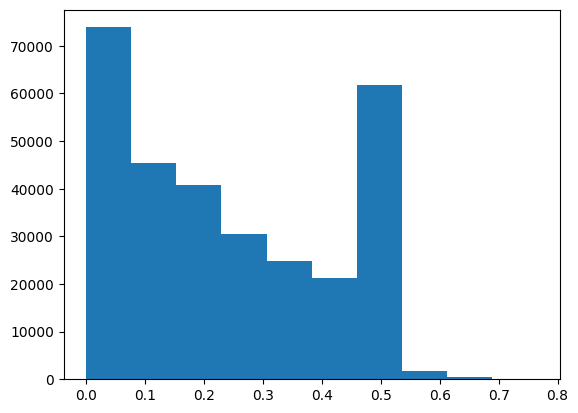

In [ ]:
print(f"{len(test_probabilities) = }")
print(f"{np.unique(test_probabilities) = }")
display(plt.hist(test_probabilities))
print(f"{len(test_predictions.cpu()) = }")
print(f"{np.unique(test_predictions.cpu()) = }")

uncomment below to make a recommendation for a user and proved a valid user_id or if a custom user was added then provide that user_id

In [ ]:
# recommend_music(TOP_K_AUDIO_RECOMMENDATION, saved_best_hyperparam_model, unique_user_id, unique_music_id, CUSTOM_USER_ID, data, DEVICE, verbose=True)

In [ ]:
print(best_hyperparms)

{'max_num_epochs': 30, 'device': device(type='cuda'), 'num_workers': 2, 'gnn_hidden_channels': 32, 'mlp_hidden_channels': 32, 'neg_sampling_ratio': 3, 'num_attention_heads': 3, 'concatenate_gat_gnn_heads_output': False, 'num_hops': 2, 'num_neighbors': [19, 17], 'batch_size': 128, 'dropout': 0.23008627717855631, 'optimizer_learning_rate': 0.00036999647694896967, 'weight_decay': 0.00017750095130720977}
